In [1]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Temperate Continental Climate

The Temperate Continental climate can be found in the Center East of the USA, parts of Kansas, Missouri and other states are located in this climate. This climate is characterized by mild to cold winters and hot summers. The average winter temperature is around 0 degrees Celcius, where in the summer the temperature averages around 27 degrees Celcius. Rain falls mostly during spring and summer, with some snowfall in the winter. 

This well is situated near Saint Louis in Missouri on a height of 129.79 meters. The well is part of the Holocene Alluvium and it is classified as an unconfined aquifer. The water in the well is between 2 to 8 meters below the ground surface. The lithology of the well is unknown.


The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [2]:
map = folium.Map(location=[38.81, -90.15], zoom_start=6)
folium.Marker([38.75, -90.37], popup='Weather Station').add_to(map)
folium.Marker([38.81, -90.15], popup='Well').add_to(map);

In [3]:
map

### Importing Data

#### Saint Louis, Well 384849090092001
#### Groundwater series

In [4]:
height = 129.79 # meters above mean sea level

head_import = pd.read_csv('GW_Data/StLouis_384849090092001.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

In [5]:
head

Date and Time
1957-10-31    122.404188
1957-11-30    122.163904
1957-12-31    121.890600
1958-01-31    121.708228
1958-02-28    121.455244
                 ...    
2024-05-26    125.440504
2024-05-27    125.522800
2024-05-28    125.562424
2024-05-29    125.583760
2024-05-30    125.632528
Name: Value, Length: 1960, dtype: float64

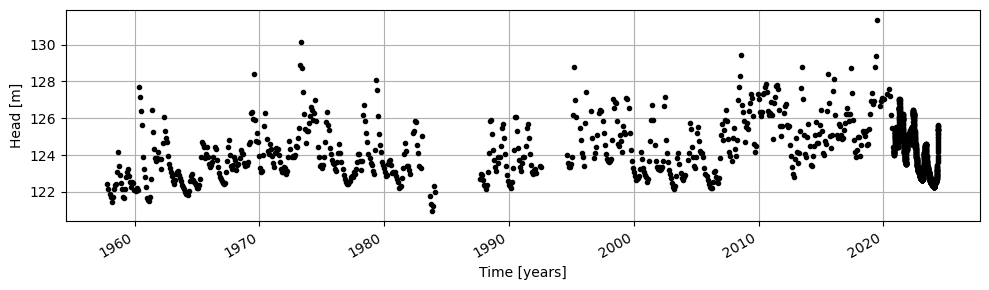

In [6]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [8]:
prec = pd.read_csv('Prec_temp/StLouis_4008631.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'PRCP'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

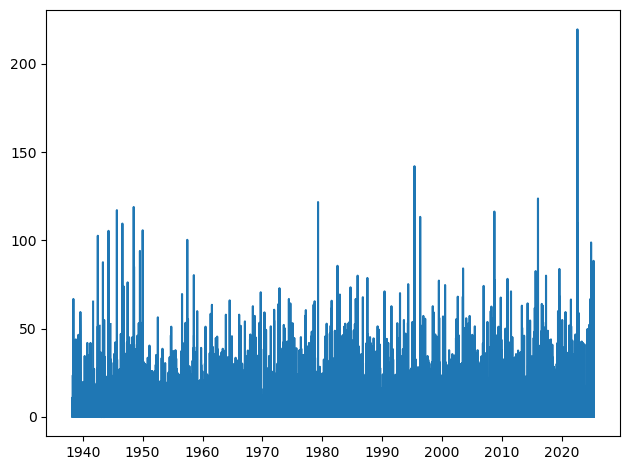

In [9]:
plt.plot(PRCP)

#### Evaporation

In [11]:
evap = pd.read_csv('Evap/StLouis.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'Hargreaves'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

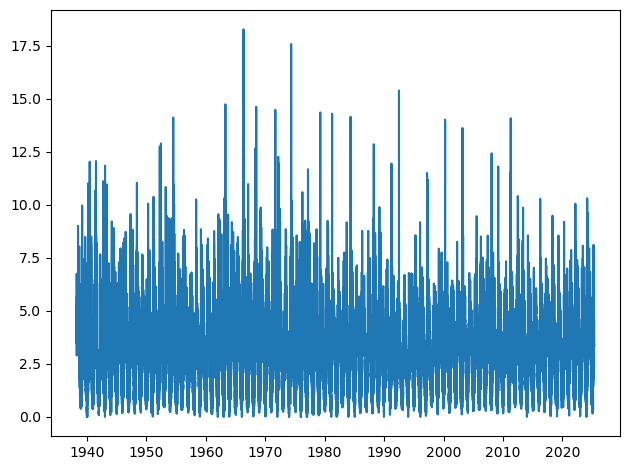

In [12]:
plt.plot(EPOT)

### Pastas Application

#### Resampling data for evenly spaced time steps

In [13]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

#### Basic Pastas Model

In [15]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    21                     EVP        39.49
nobs    1960                   R2          0.39
noise   False                  RMSE        1.07
tmin    1957-10-31 00:00:00    AICc      269.50
tmax    2024-05-30 00:00:00    BIC       297.38
freq    D                      Obj      1118.72
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (5 optimized)
               optimal     initial  vary
rch_A         1.332087    0.122317  True
rch_n         2.230170    1.000000  True
rch_a       113.013759   10.000000  True
rch_f        -2.000000   -1.000000  True
constant_d  128.468429  124.193504  True

Warnings! (1)
Parameter 'rch_f' on lower bound: -2.00e+00


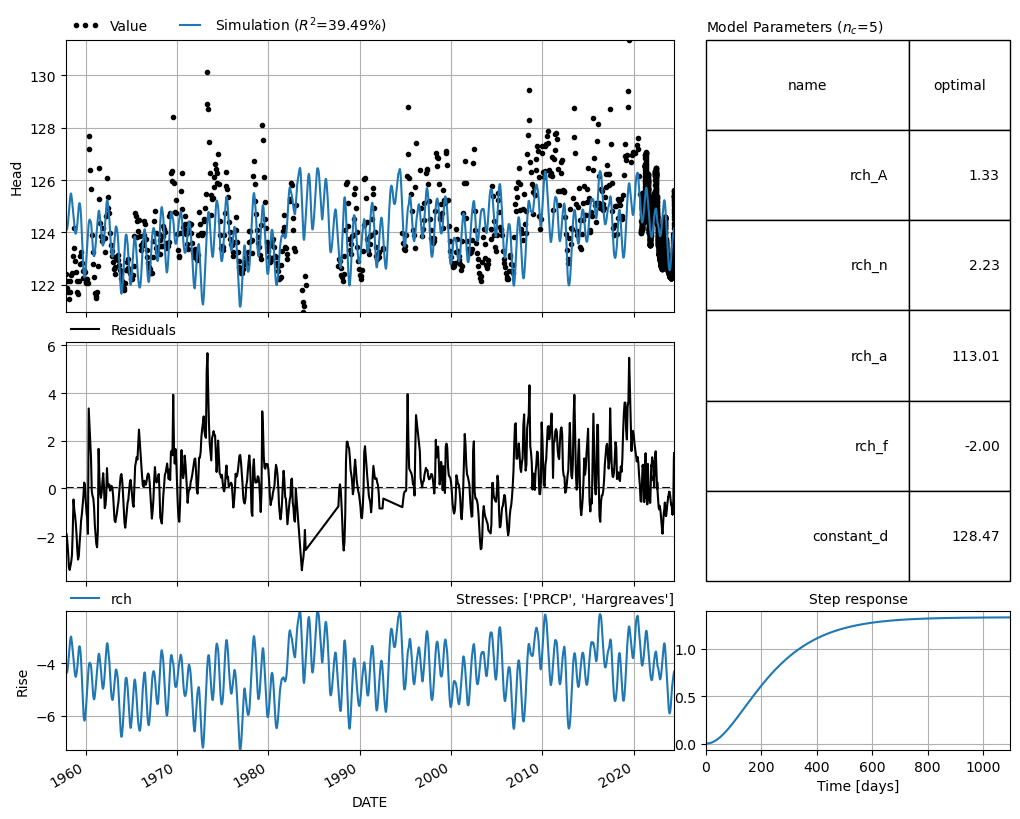

In [17]:
ml.plots.results();

#### Resample monthly

In [18]:
head_resampled = head.resample('M').last()

In [19]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 92 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    32                     EVP       34.82
nobs    708                    R2         0.35
noise   False                  RMSE       1.29
tmin    1957-10-31 00:00:00    AICc     373.64
tmax    2024-05-31 00:00:00    BIC      396.36
freq    D                      Obj      591.57
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (5 optimized)
               optimal     initial  vary
rch_A         1.435540    0.122317  True
rch_n         2.644354    1.000000  True
rch_a        68.524321   10.000000  True
rch_f        -0.935090   -1.000000  True
constant_d  124.546595  124.338098  True


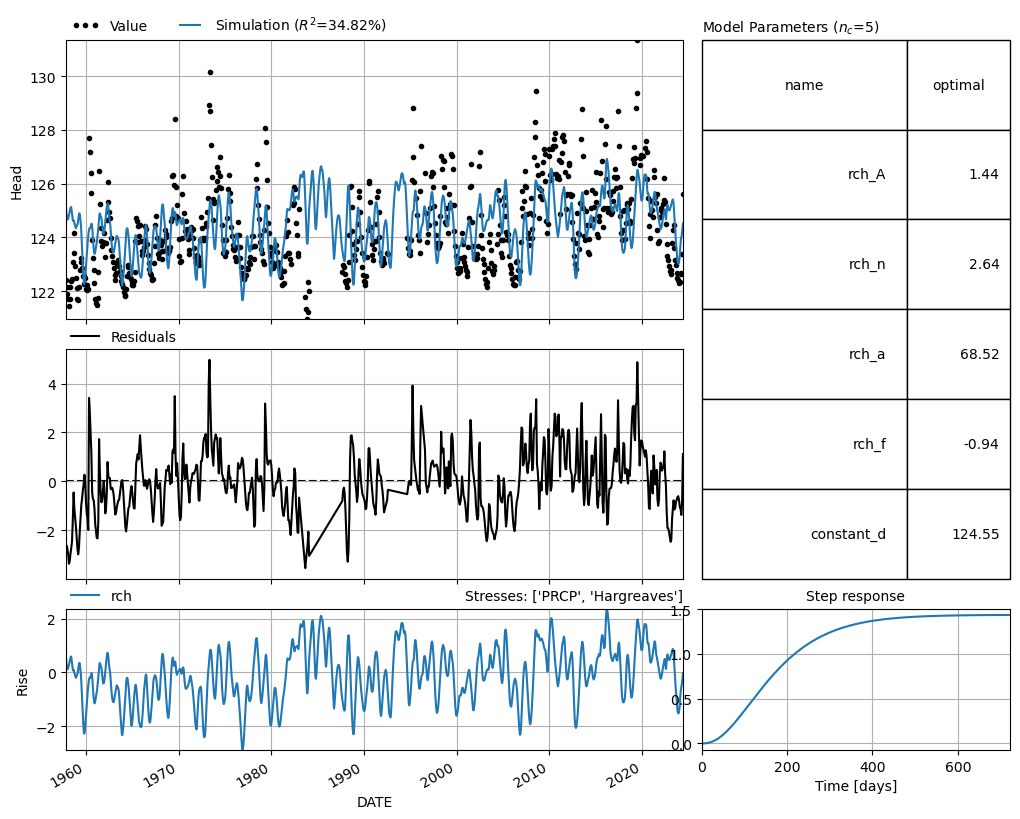

In [20]:
ml.plots.results();

#### Different recharge models and response functions

In [61]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'Value': 92 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    92                     EVP       44.80
nobs    708                    R2         0.45
noise   False                  RMSE       1.19
tmin    1957-10-31 00:00:00    AICc     264.17
tmax    2024-05-31 00:00:00    BIC      304.98
freq    D                      Obj      501.02
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (9 optimized)
               optimal     initial  vary
rch_A         5.780415    0.675699  True
rch_n         0.978372    1.000000  True
rch_a       249.874473   10.000000  True
rch_scap      1.204188    1.500000  True
rch_alpha     0.458500    1.000000  True
rch_ksat      1.110290    1.000000  True
rch_beta      0.062256    0.500000  True
rch_gamma     1.899906    1.000000  True
constant_d  115.930025  124.338098  True


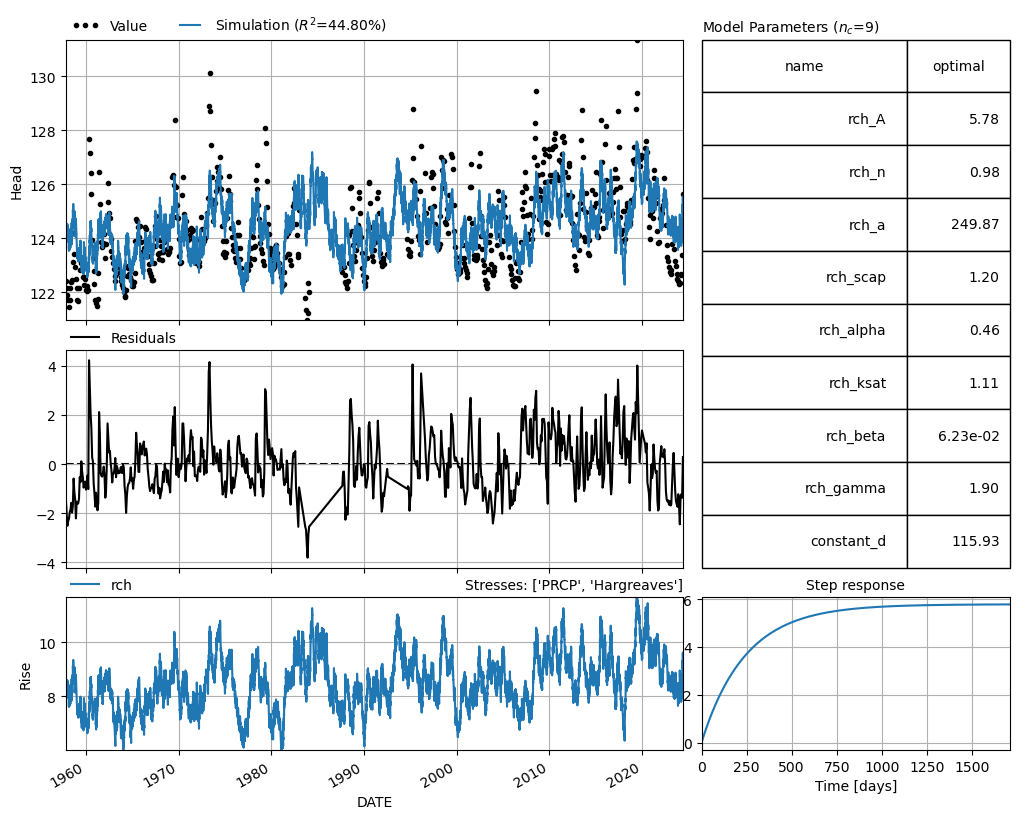

In [62]:
ml.plots.results();

In [48]:
ml3 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Berendrecht())
ml3.add_stressmodel(sm)
ml3.solve()

INFO: Time Series 'Value': 92 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    53                     EVP       36.13
nobs    708                    R2         0.36
noise   False                  RMSE       1.28
tmin    1957-10-31 00:00:00    AICc     363.27
tmax    2024-05-31 00:00:00    BIC      395.05
freq    D                      Obj      579.63
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (7 optimized)
               optimal     initial   vary
rch_A         8.857963    0.859986   True
rch_n         1.463242    1.000000   True
rch_a        59.143916   10.000000   True
rch_fi        0.900000    0.900000  False
rch_fc        1.000000    1.000000  False
rch_sr        0.250000    0.250000  False
rch_de      999.990253  250.000000   True
rch_l        -3.144986    2.000000   True
rch_m         0.500000    0.500000  False
rch_ks        7.372663  100.000000   True
constant_d  121.419989  124.338098   True

Warnings! (2)
Parameter 'rch_de' on upper boun

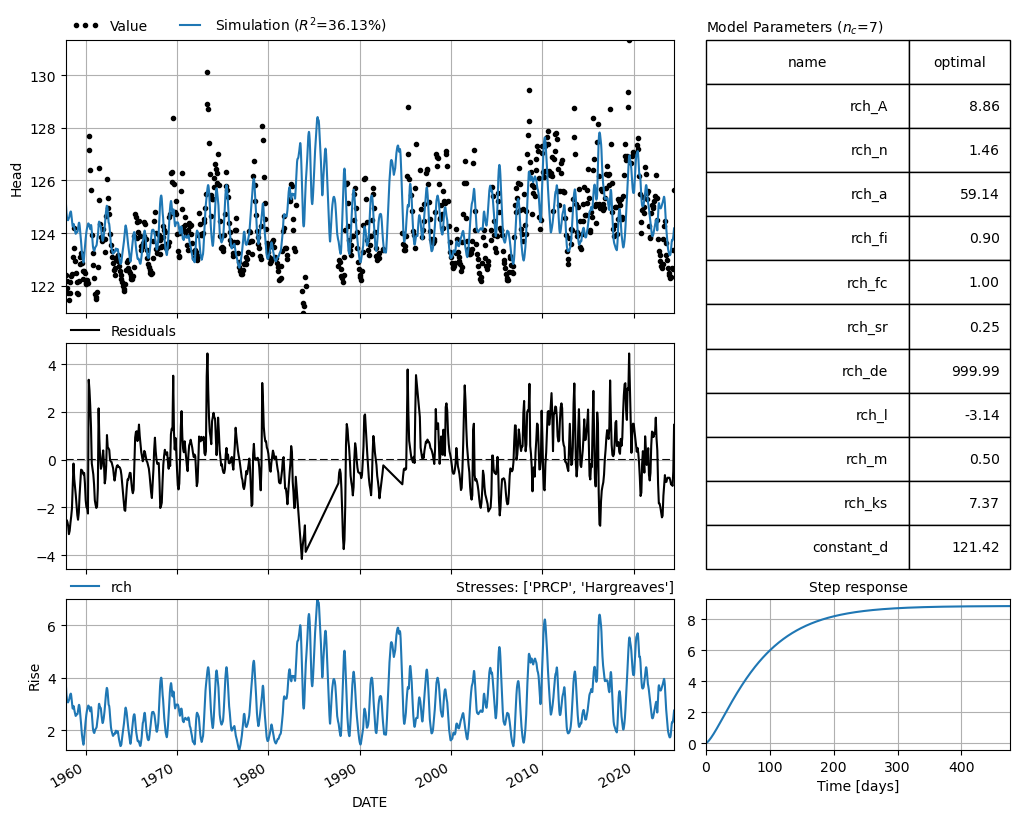

In [49]:
ml.plots.results();

#### Add Groundwater Uptake

As the groundwater is close to the surface, the gw_uptake feature can be applied

In [56]:
ml1 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml1.add_stressmodel(sm)
ml1.solve()

INFO: Time Series 'Value': 92 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    66                     EVP       42.73
nobs    708                    R2         0.43
noise   False                  RMSE       1.21
tmin    1957-10-31 00:00:00    AICc     288.13
tmax    2024-05-31 00:00:00    BIC      324.43
freq    D                      Obj      519.76
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (8 optimized)
               optimal     initial   vary
rch_A         5.396544    0.302452   True
rch_n         1.965996    1.000000   True
rch_a        93.379275   10.000000   True
rch_srmax     8.488255  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks      429.365155  100.000000   True
rch_gamma     3.141895    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
rch_gf        0.226666    1.000000   True
constant_d  121.452145  124.338098   True


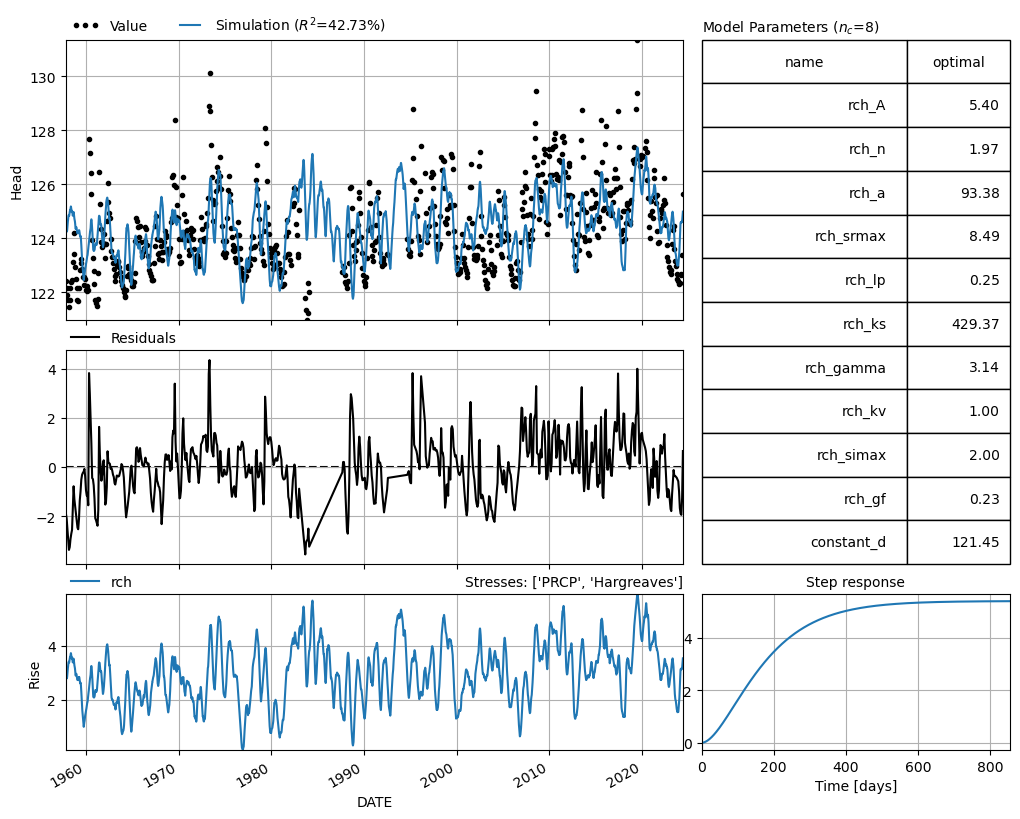

In [51]:
ml1.plots.results();

In [57]:
ml2 = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel())
ml2.add_stressmodel(sm)
ml2.solve()

INFO: Time Series 'Value': 92 nan-value(s) was/were found and filled with: drop.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 282 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 5 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                Fit Statistics
nfev    58                     EVP       36.10
nobs    708                    R2         0.36
noise   False                  RMSE       1.28
tmin    1957-10-31 00:00:00    AICc     363.60
tmax    2024-05-31 00:00:00    BIC      395.38
freq    D                      Obj      579.90
warmup  3650 days 00:00:00     ___            
solver  LeastSquares           Interp.      No

Parameters (7 optimized)
               optimal     initial   vary
rch_A         7.113453    0.423415   True
rch_n         1.450098    1.000000   True
rch_a        59.869428   10.000000   True
rch_srmax   528.583311  250.000000   True
rch_lp        0.250000    0.250000  False
rch_ks        1.291793  100.000000   True
rch_gamma     0.792300    2.000000   True
rch_kv        1.000000    1.000000  False
rch_simax     2.000000    2.000000  False
constant_d  121.411804  124.338098   True


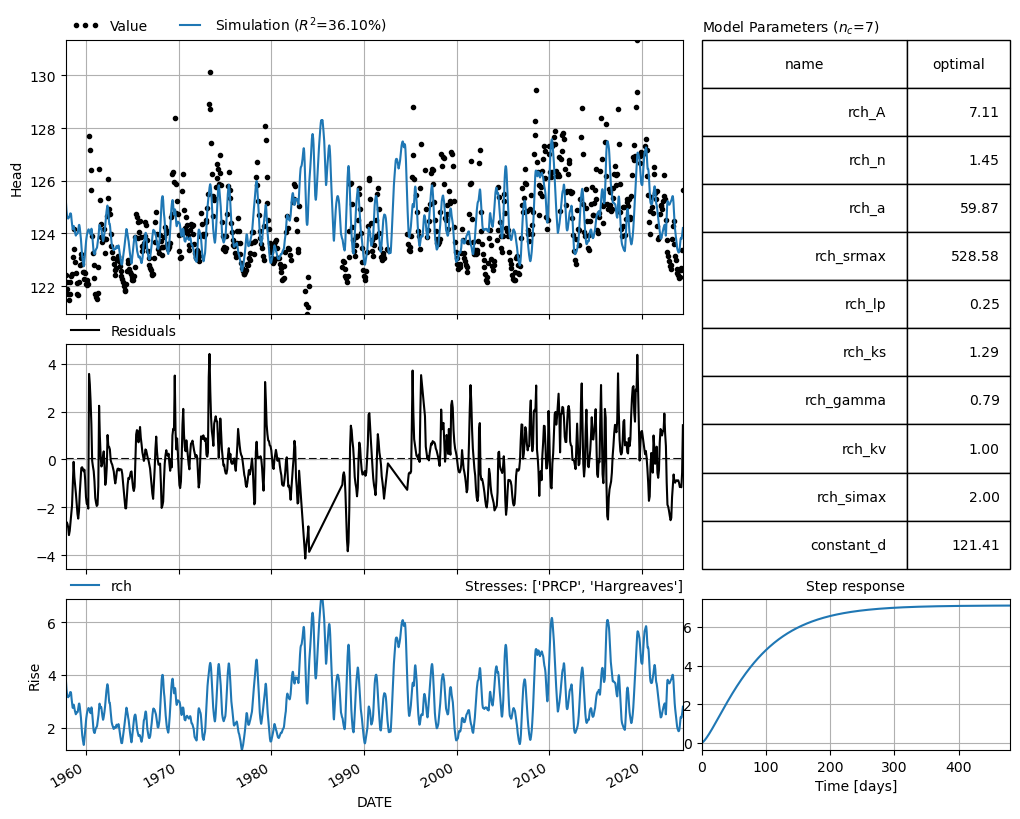

In [58]:
ml2.plots.results();

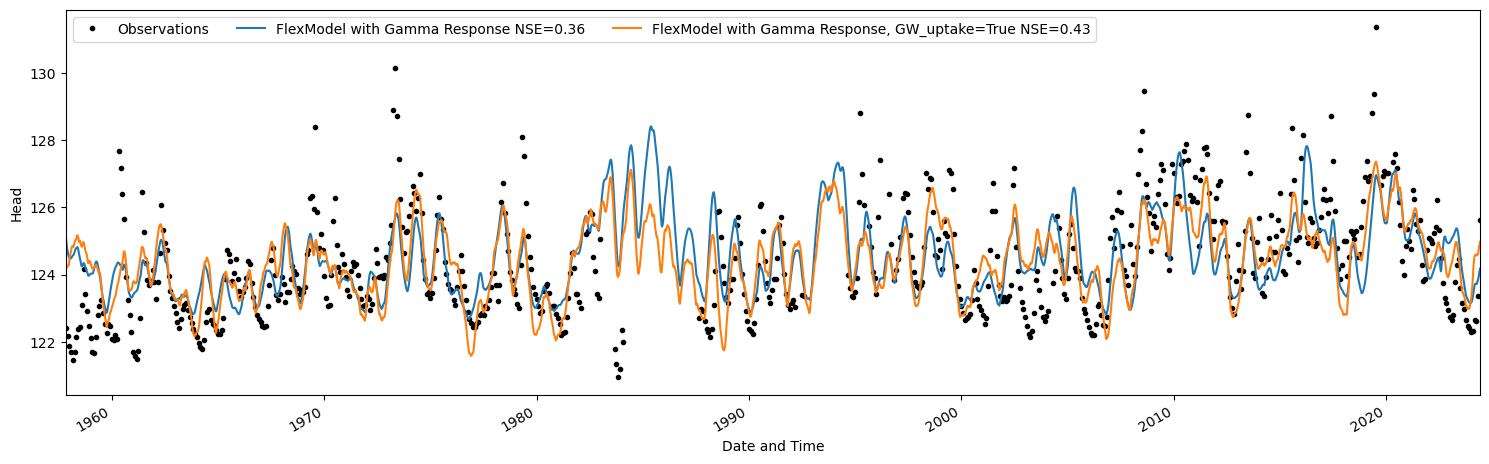

In [59]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "FlexModel with Gamma Response NSE={:.2f}".format(ml2.stats.nse()),
        "FlexModel with Gamma Response, GW_uptake=True NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)

Groundwater uptake vs. Peterson

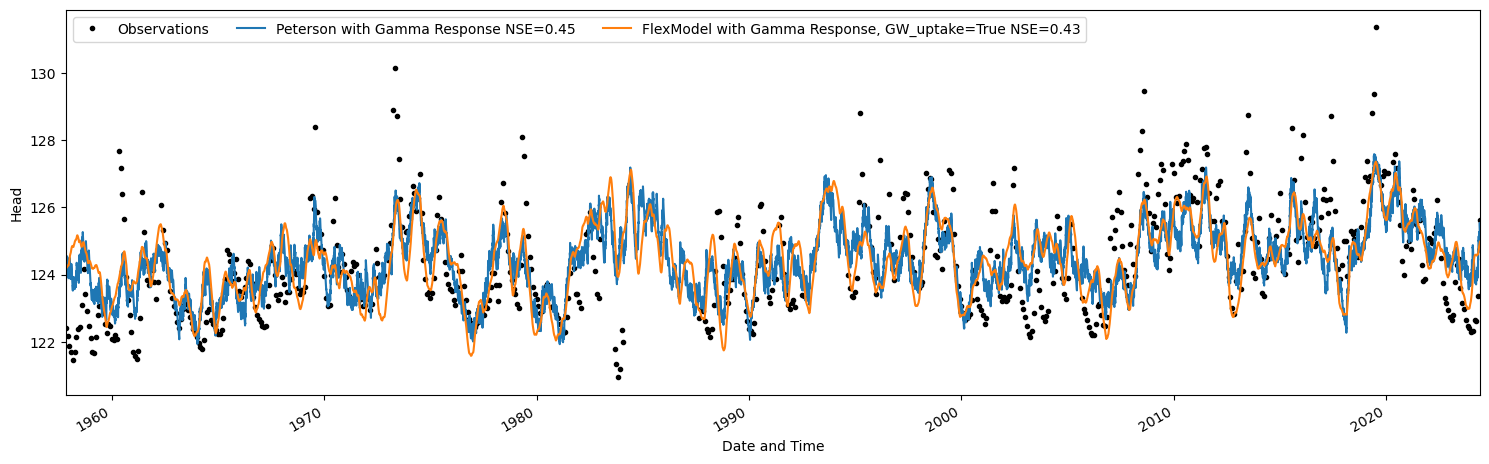

In [63]:
ax = ml.plot(figsize=(15, 5))
ml1.simulate().plot(ax=ax)
plt.legend(
    [
        "Observations",
        "Peterson with Gamma Response NSE={:.2f}".format(ml.stats.nse()),
        "FlexModel with Gamma Response, GW_uptake=True NSE={:.2f}".format(ml1.stats.nse()),
    ],
    ncol=3,
)